In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np
import random

seed = 123
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# 데이터 로드
train_data = pd.read_csv('train.csv')

# pIC50 to IC50 변환 함수
def pIC50_to_IC50(pic50_values):
    return 10 ** (9 - pic50_values)

# SMILES 문자열에서 원소 빈도 계산 함수
def compute_element_counts(smiles):
    element_counts = {element: 0 for element in ['C', 'F', 'H', 'N', 'P', 'S']}
    mol = Chem.MolFromSmiles(smiles)
    for atom in mol.GetAtoms():
        symbol = atom.GetSymbol()
        if symbol in element_counts:
            element_counts[symbol] += 1
    return element_counts

# FormalCharge 계산 함수
def compute_formal_charge(mol):
    formal_charge = 0
    for atom in mol.GetAtoms():
        formal_charge += atom.GetFormalCharge()
    return formal_charge

# SMILES 문자열에서 물리화학적 특성 추출 함수
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    descriptors = {
        'MolWt': Descriptors.MolWt(mol),
        'TPSA': Descriptors.TPSA(mol),
        'LogP': Descriptors.MolLogP(mol),
        'NumHDonors': Descriptors.NumHDonors(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'AromaticProportion': Descriptors.FractionCSP3(mol),
        'NumAliphaticRings': Descriptors.NumAliphaticRings(mol),
        'NumAromaticRings': Descriptors.NumAromaticRings(mol),
        'RingCount': Descriptors.RingCount(mol),
        'HeavyAtomCount': Descriptors.HeavyAtomCount(mol),
        'BalabanJ': Descriptors.BalabanJ(mol),
        'MolWt_HBDonors': Descriptors.MolWt(mol) * Descriptors.NumHDonors(mol),
        'MolWt_HBAcceptors': Descriptors.MolWt(mol) * Descriptors.NumHAcceptors(mol),
        'TPSA_LogP': Descriptors.TPSA(mol) * Descriptors.MolLogP(mol),
        'HBDonors_HBAcceptors': Descriptors.NumHDonors(mol) * Descriptors.NumHAcceptors(mol),
        'LogP_NumRotatableBonds': Descriptors.MolLogP(mol) * Descriptors.NumRotatableBonds(mol),
        'SmilesLength': len(smiles),
        'FormalCharge': compute_formal_charge(mol),
        'SASA': Descriptors.TPSA(mol),  
        'MolVol': Descriptors.MolMR(mol),  
        'NumHeteroAtoms': Descriptors.NumHeteroatoms(mol)
    }
    element_counts = compute_element_counts(smiles)
    descriptors.update(element_counts)
    
    return descriptors

# 훈련 데이터의 물리화학적 특성 추출
train_descriptors = train_data['Smiles'].apply(compute_descriptors)
train_descriptors_df = pd.DataFrame(train_descriptors.tolist())

# NaN 값 처리: 평균으로 대체
train_descriptors_df.fillna(train_descriptors_df.mean(), inplace=True)

# 피처 선택
selected_features = [
  'LogP', 'AromaticProportion', 'NumAliphaticRings','BalabanJ',
    'C', 'F', 'H', 'S', 'FormalCharge','N','P'
]

selected_features2 = [
    'TPSA', 'NumRotatableBonds', 'NumAromaticRings',
    'MolWt', 'MolWt_HBDonors', 'FormalCharge','LogP','RingCount','SASA','MolWt_HBAcceptors'
]


# 피처 선택에 따른 데이터프레임 생성
filtered_features_df = train_descriptors_df[selected_features]
filtered_features_df2 = train_descriptors_df[selected_features2]

# StandardScaler를 사용하여 데이터를 정규화
from sklearn.preprocessing import RobustScaler

scaler = StandardScaler()
sacler2 = RobustScaler()

scaled_features_df = pd.DataFrame(scaler.fit_transform(filtered_features_df), columns=filtered_features_df.columns)
scaled_features_df2 = pd.DataFrame(sacler2.fit_transform(filtered_features_df2), columns=filtered_features_df2.columns)

# 데이터 분할 (훈련/검증)
X_train1, X_val1, y_train, y_val = train_test_split(scaled_features_df, train_data['pIC50'], test_size=0.2, random_state=123)
X_train2, X_val2, _, _ = train_test_split(scaled_features_df2, train_data['pIC50'], test_size=0.2, random_state=123)

# 첫 번째 신경망 모델 정의
model_1 = Sequential([
    Dense(128, input_dim=X_train1.shape[1], activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='swish'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# 모델 컴파일
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 첫 번째 모델 학습
history_1 = model_1.fit(X_train1, y_train, epochs=100, batch_size=32, validation_data=(X_val1, y_val))

# 두 번째 신경망 모델 정의
model_2 = Sequential([
    Dense(256, input_dim=X_train2.shape[1], activation='relu'),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(32, activation='swish'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# 모델 컴파일
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# 두 번째 모델 학습
history_2 = model_2.fit(X_train2, y_train, epochs=350, batch_size=30, validation_data=(X_val2, y_val))

# 예측 및 각각의 모델 평가
y_val_pred_1 = model_1.predict(X_val1)
y_val_pred_2 = model_2.predict(X_val2)

# 각각의 모델에 대한 평가 점수 계산
def calculate_score(y_true_pic50, y_pred_ic50):
    y_true_ic50 = pIC50_to_IC50(y_true_pic50)
    
    # Calculate Normalized RMSE in IC50(nM) (A)
    mse = mean_squared_error(y_true_ic50, y_pred_ic50)
    rmse = np.sqrt(mse)
    A = rmse / np.mean(y_true_ic50)
    
    # Calculate Correct Ratio (B)
    correct_ratio = np.mean(np.abs(y_true_pic50 - np.log10(10**9 / y_pred_ic50)) <= 0.5)
    
    # Calculate final score
    score = 0.5 * (1 - min(A, 1)) + 0.5 * correct_ratio
    return score, A, correct_ratio

# 모델 1 평가
score_1, A_1, B_1 = calculate_score(y_val, pIC50_to_IC50(y_val_pred_1.flatten()))
print(f"Model 1 - RMSE: {np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), pIC50_to_IC50(y_val_pred_1.flatten()))):.4f}, Score: {score_1:.4f}, Normalized RMSE (A): {A_1:.4f}, Correct Ratio (B): {B_1:.4f}")

# 모델 2 평가
score_2, A_2, B_2 = calculate_score(y_val, pIC50_to_IC50(y_val_pred_2.flatten()))
print(f"Model 2 - RMSE: {np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), pIC50_to_IC50(y_val_pred_2.flatten()))):.4f}, Score: {score_2:.4f}, Normalized RMSE (A): {A_2:.4f}, Correct Ratio (B): {B_2:.4f}")

# 앙상블 예측 (평균)
y_val_pred_ensemble = (y_val_pred_1.flatten() + y_val_pred_2.flatten()) / 2
y_val_pred_ic50_ensemble = pIC50_to_IC50(y_val_pred_ensemble)

# 앙상블 모델 평가
score_ensemble, A_ensemble, B_ensemble = calculate_score(y_val, y_val_pred_ic50_ensemble)
print(f"Ensemble Neural Network Model - RMSE: {np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), y_val_pred_ic50_ensemble)):.4f}, Score: {score_ensemble:.4f}, Normalized RMSE (A): {A_ensemble:.4f}, Correct Ratio (B): {B_ensemble:.4f}")



Epoch 1/100


2024-09-17 21:49:13.852295: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


49/49 [==============================] - 0s 3ms/step - loss: 27.7906 - val_loss: 9.1831
Epoch 2/100
49/49 [==============================] - 0s 1ms/step - loss: 6.1531 - val_loss: 5.4373
Epoch 3/100
49/49 [==============================] - 0s 1ms/step - loss: 2.9301 - val_loss: 2.1284
Epoch 4/100
49/49 [==============================] - 0s 1ms/step - loss: 1.6590 - val_loss: 1.4480
Epoch 5/100
49/49 [==============================] - 0s 1ms/step - loss: 1.2056 - val_loss: 1.1061
Epoch 6/100
49/49 [==============================] - 0s 1ms/step - loss: 1.0115 - val_loss: 0.8889
Epoch 7/100
49/49 [==============================] - 0s 1ms/step - loss: 0.8343 - val_loss: 0.8160
Epoch 8/100
49/49 [==============================] - 0s 1ms/step - loss: 0.7459 - val_loss: 0.7428
Epoch 9/100
49/49 [==============================] - 0s 1ms/step - loss: 0.6959 - val_loss: 0.8055
Epoch 10/100
49/49 [==============================] - 0s 1ms/step - loss: 0.6632 - val_loss: 0.6871
Epoch 11/100
49/49 [

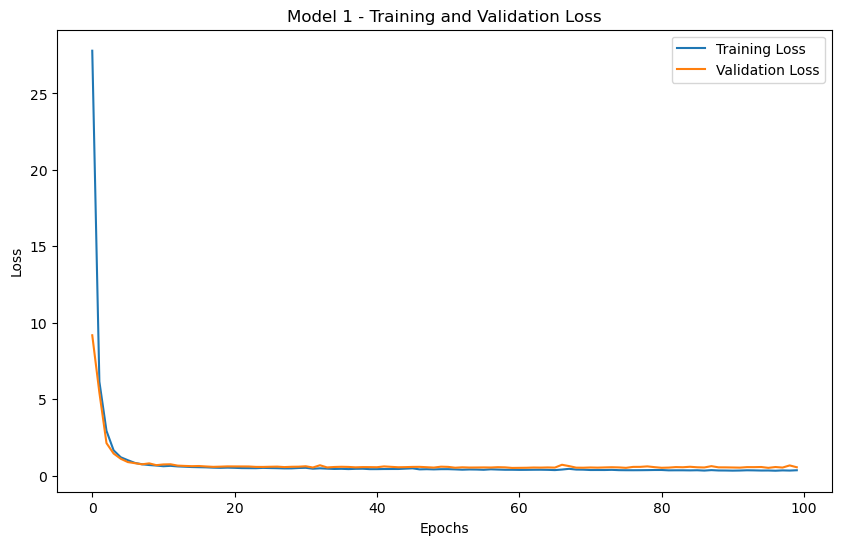

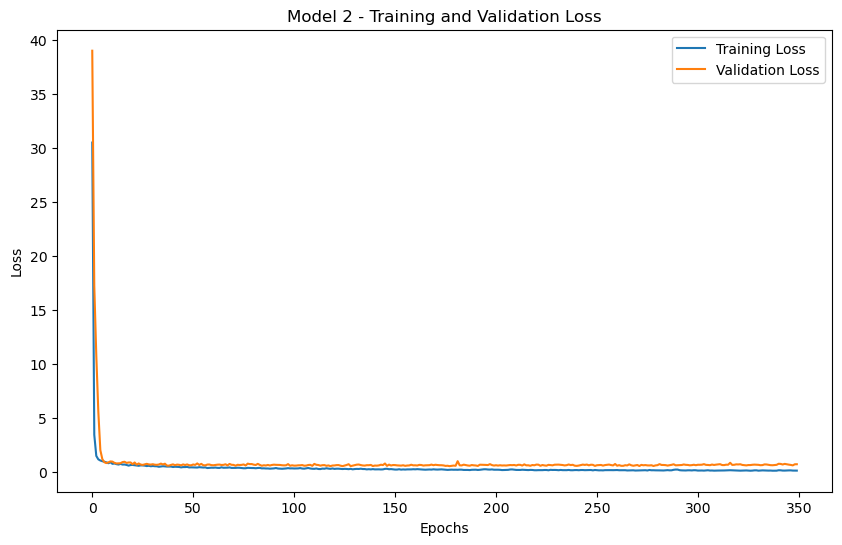

/var/folders/3d/nr_splbx619_jz_ryc6wg6740000gn/T/ipykernel_9162/4062292706.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, color='red')


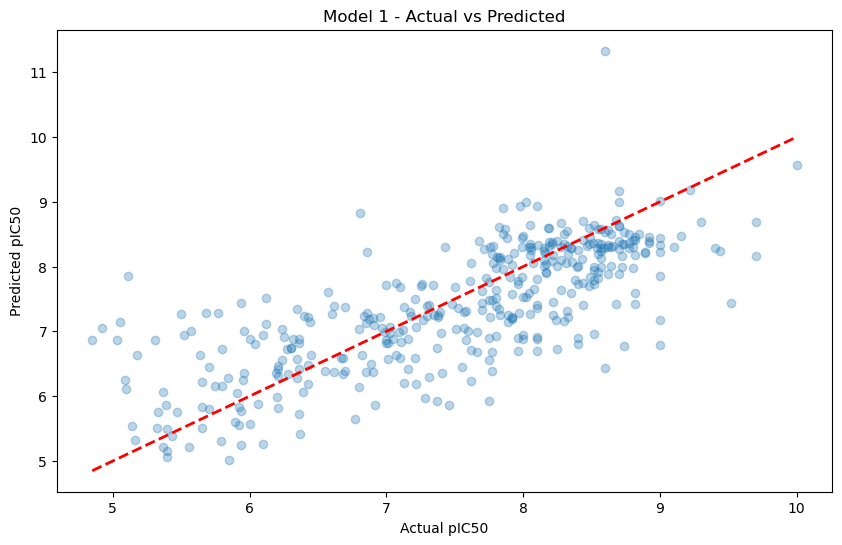

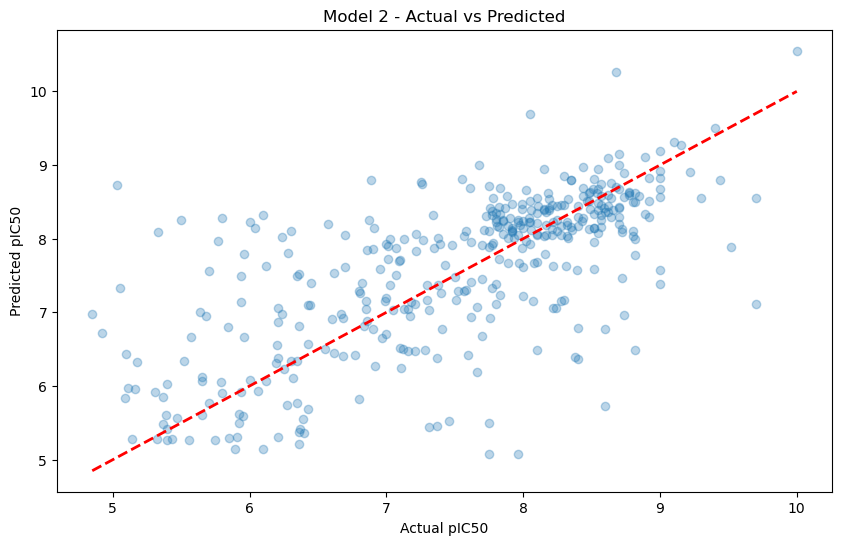

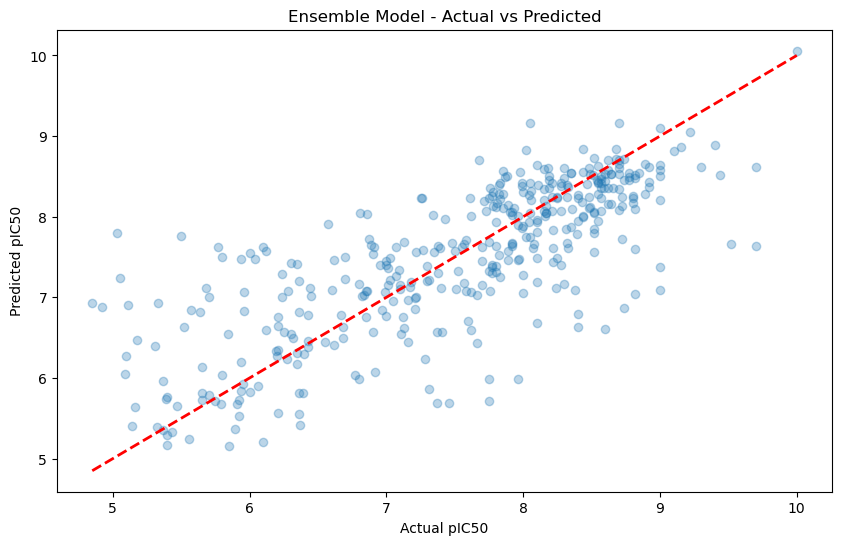

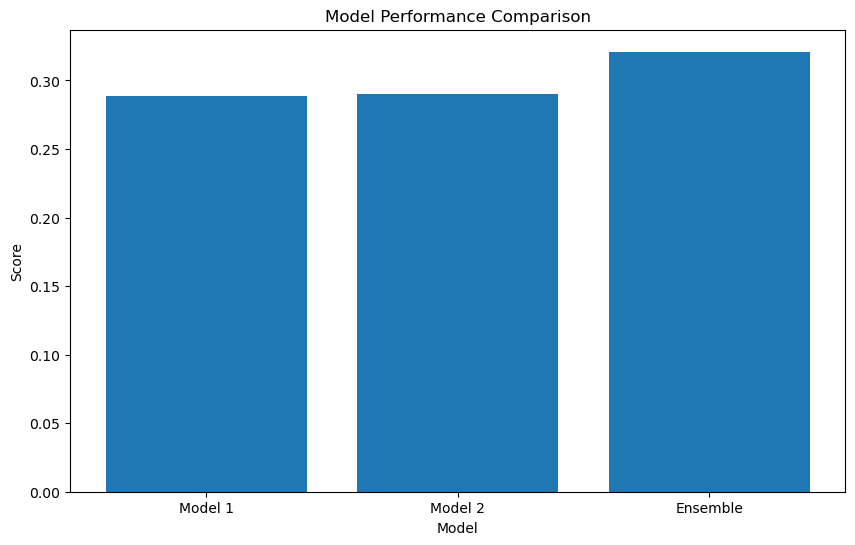

In [5]:
import matplotlib.pyplot as plt

# 1. 모델 학습 과정의 손실(loss) 변화 시각화
def plot_loss(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{title} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# 모델 1 학습 과정 시각화
plot_loss(history_1, 'Model 1')

# 모델 2 학습 과정 시각화
plot_loss(history_2, 'Model 2')

# 2. 예측값과 실제값 비교 시각화
def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.3)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2, color='red')
    plt.title(f'{title} - Actual vs Predicted')
    plt.xlabel('Actual pIC50')
    plt.ylabel('Predicted pIC50')
    plt.show()

# 모델 1 예측 vs 실제값
plot_predictions(y_val, y_val_pred_1.flatten(), 'Model 1')

# 모델 2 예측 vs 실제값
plot_predictions(y_val, y_val_pred_2.flatten(), 'Model 2')

# 앙상블 모델 예측 vs 실제값
plot_predictions(y_val, y_val_pred_ensemble, 'Ensemble Model')

# 3. 모델 성능 비교 시각화
def plot_performance(scores, labels, title):
    plt.figure(figsize=(10, 6))
    x = range(len(labels))
    plt.bar(x, scores, tick_label=labels)
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel('Score')
    plt.show()

# 성능 점수 계산
models = ['Model 1', 'Model 2', 'Ensemble']
scores = [score_1, score_2, score_ensemble]

# 성능 비교 그래프
plot_performance(scores, models, 'Model Performance Comparison')

In [6]:
import pandas as pd

# 각 모델의 성능 수치 계산
results = {
    'Model': ['Model 1', 'Model 2', 'Ensemble'],
    'RMSE': [
        np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), pIC50_to_IC50(y_val_pred_1.flatten()))),
        np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), pIC50_to_IC50(y_val_pred_2.flatten()))),
        np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), y_val_pred_ic50_ensemble))
    ],
    'Normalized RMSE (A)': [A_1, A_2, A_ensemble],
    'Correct Ratio (B)': [B_1, B_2, B_ensemble],
    'Final Score': [score_1, score_2, score_ensemble]
}

# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

# 성능 수치 출력
print(results_df)

      Model         RMSE  Normalized RMSE (A)  Correct Ratio (B)  Final Score
0   Model 1  1638.146302             2.976132           0.578005     0.289003
1   Model 2  1802.332900             3.274421           0.580563     0.290281
2  Ensemble  1595.604852             2.898844           0.641944     0.320972


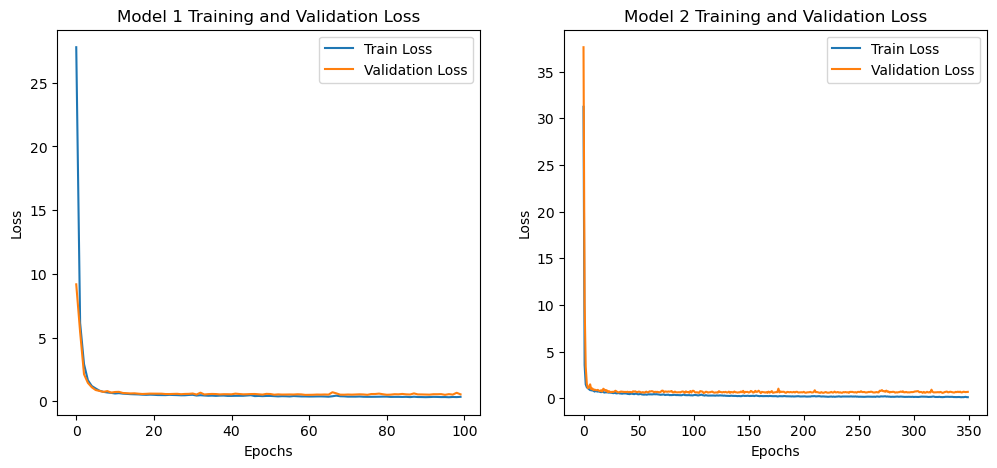

In [4]:
plt.figure(figsize=(12, 5))

# Model 1 학습 과정 시각화
plt.subplot(1, 2, 1)
plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Model 1 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Model 2 학습 과정 시각화
plt.subplot(1, 2, 2)
plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Model 2 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

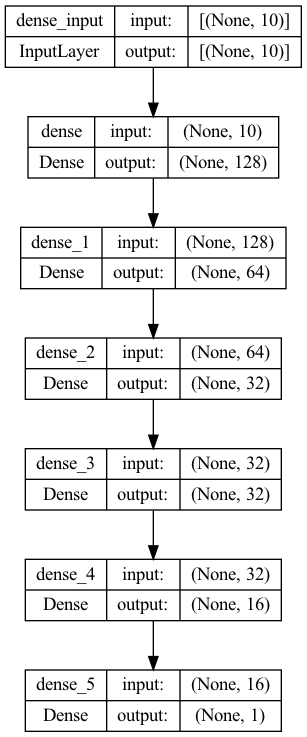

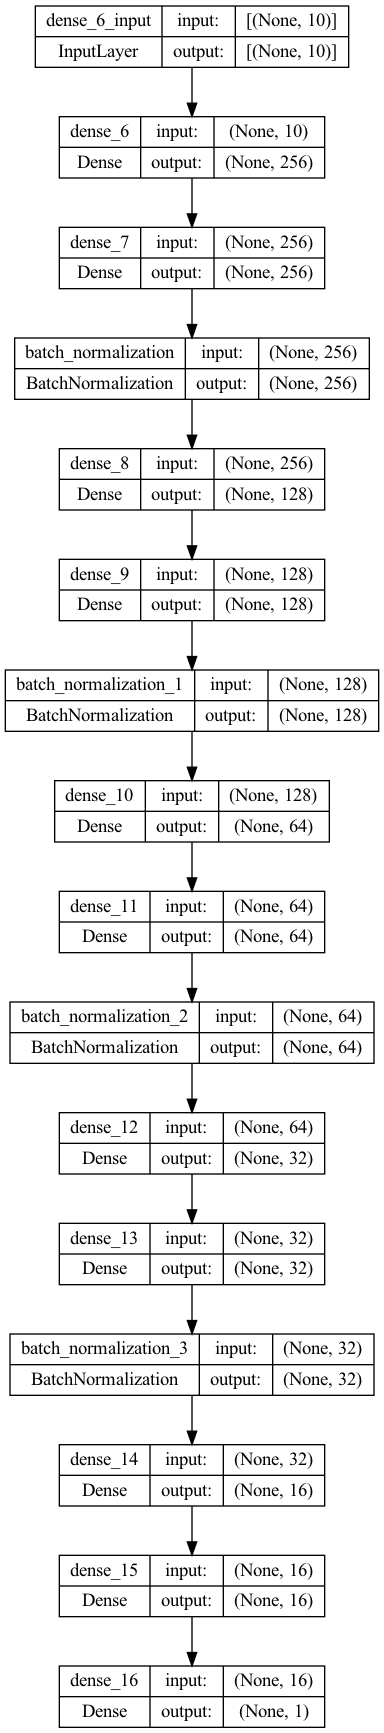

In [2]:
from keras.utils import plot_model
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras.optimizers import Adam

# 첫 번째 신경망 모델 정의
model_1 = Sequential([
    Dense(128, input_dim=10, activation='relu'),  # input_dim은 예시로 10을 사용했습니다.
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='swish'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# 두 번째 신경망 모델 정의
model_2 = Sequential([
    Dense(256, input_dim=10, activation='relu'),  # input_dim은 예시로 10을 사용했습니다.
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(32, activation='relu'),
    Dense(32, activation='swish'),
    BatchNormalization(),
    Dense(16, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

# 모델 구조 시각화 및 저장
plot_model(model_1, to_file='model_1_structure.png', show_shapes=True, show_layer_names=True)
plot_model(model_2, to_file='model_2_structure.png', show_shapes=True, show_layer_names=True)

# 시각화한 이미지 보기
from IPython.display import Image

# 첫 번째 모델 시각화
display(Image(filename='model_1_structure.png'))

# 두 번째 모델 시각화
display(Image(filename='model_2_structure.png'))

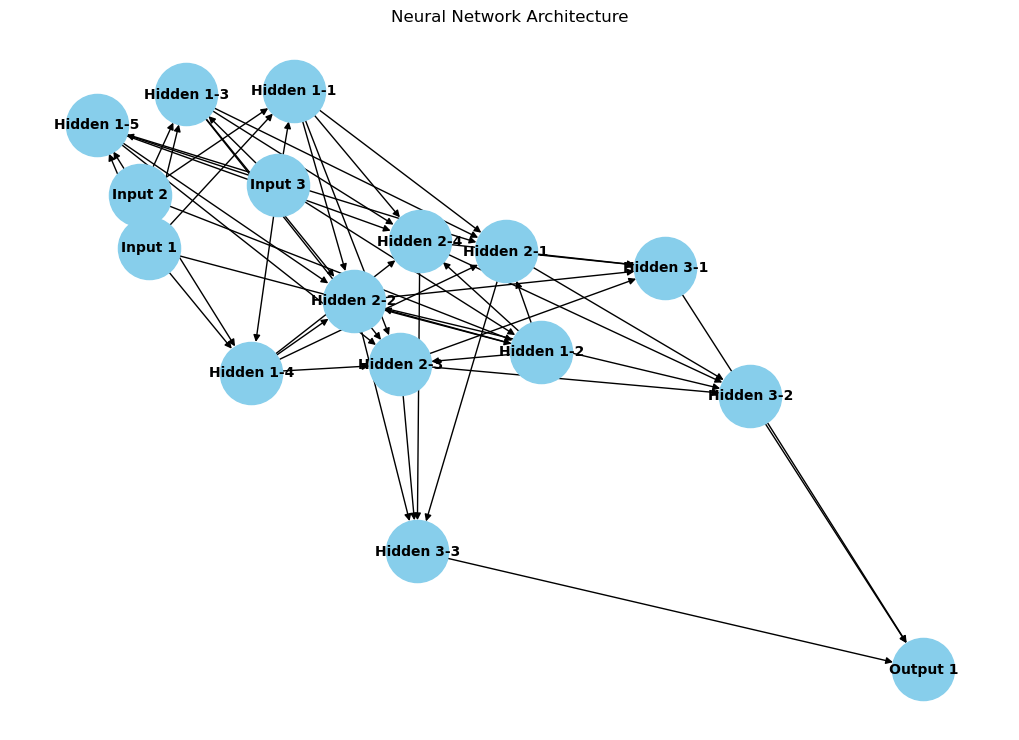

In [3]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_neural_network():
    # 그래프 초기화
    G = nx.DiGraph()

    # 입력층, 은닉층, 출력층의 노드 수
    input_layer_size = 3
    hidden_layers = [5, 4, 3]  # 각 은닉층의 노드 수
    output_layer_size = 1

    # 노드 추가
    for i in range(input_layer_size):
        G.add_node(f'Input {i+1}')

    for i, layer_size in enumerate(hidden_layers):
        for j in range(layer_size):
            G.add_node(f'Hidden {i+1}-{j+1}')

    for i in range(output_layer_size):
        G.add_node(f'Output {i+1}')

    # 엣지 추가
    for i in range(input_layer_size):
        for j in range(hidden_layers[0]):
            G.add_edge(f'Input {i+1}', f'Hidden 1-{j+1}')

    for i in range(len(hidden_layers) - 1):
        for j in range(hidden_layers[i]):
            for k in range(hidden_layers[i + 1]):
                G.add_edge(f'Hidden {i+1}-{j+1}', f'Hidden {i+2}-{k+1}')

    for i in range(hidden_layers[-1]):
        for j in range(output_layer_size):
            G.add_edge(f'Hidden {len(hidden_layers)}-{i+1}', f'Output {j+1}')

    # 레이아웃 설정 및 시각화
    pos = nx.spring_layout(G)
    plt.figure(figsize=(10, 7))
    nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_weight='bold')
    plt.title("Neural Network Architecture")
    plt.show()

plot_neural_network()

In [19]:
import pandas as pd

# 모델별 평가 점수 데이터프레임 생성
evaluation_df = pd.DataFrame({
    'Model': ['Model 1', 'Model 2', 'Ensemble'],
    'RMSE': [np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), pIC50_to_IC50(y_val_pred_1.flatten()))),
             np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), pIC50_to_IC50(y_val_pred_2.flatten()))),
             np.sqrt(mean_squared_error(pIC50_to_IC50(y_val), y_val_pred_ic50_ensemble))],
    'Score': [score_1, score_2, score_ensemble],
    'Normalized RMSE (A)': [A_1, A_2, A_ensemble],
    'Correct Ratio (B)': [B_1, B_2, B_ensemble]
})

# 데이터프레임 출력
print(evaluation_df)

      Model         RMSE     Score  Normalized RMSE (A)  Correct Ratio (B)
0   Model 1  1601.230453  0.280051             2.909065           0.560102
1   Model 2  1738.754031  0.322251             3.158913           0.644501
2  Ensemble  1560.237351  0.324808             2.834590           0.649616


In [20]:
# 테스트 데이터 로드
test = pd.read_csv('./test.csv')

# 테스트 데이터의 물리화학적 특성 추출
test_descriptors = test['Smiles'].apply(compute_descriptors)
test_descriptors_df = pd.DataFrame(test_descriptors.tolist())

# NaN 값 처리: 평균으로 대체
test_descriptors_df.fillna(train_descriptors_df.mean(), inplace=True)  # 훈련 데이터의 평균 사용

# 테스트 데이터에 대해 동일한 피처 선택 및 정규화 적용
filtered_test_features_df = test_descriptors_df[selected_features]
filtered_test_features_df2 = test_descriptors_df[selected_features2]

scaled_test_features_df = pd.DataFrame(scaler.transform(filtered_test_features_df), columns=filtered_test_features_df.columns)
scaled_test_features_df2 = pd.DataFrame(sacler2.transform(filtered_test_features_df2), columns=filtered_test_features_df2.columns)

# 모델 1에 대한 예측
test_y_pred_1 = model_1.predict(scaled_test_features_df)

# 모델 2에 대한 예측
test_y_pred_2 = model_2.predict(scaled_test_features_df2)

# 앙상블 예측 (평균)
test_y_pred_ensemble = (test_y_pred_1.flatten() + test_y_pred_2.flatten()) / 2

# pIC50에서 IC50(nM)로 변환
test_y_pred_ic50 = pIC50_to_IC50(test_y_pred_ensemble)

# 결과를 제출 형식으로 변환
submit = pd.read_csv('./sample_submission.csv')
submit['IC50_nM'] = test_y_pred_ic50
submit.head()

4/4 [==============================] - 0s 1ms/step


,ID,IC50_nM
0,TEST_000,22.013062
1,TEST_001,5.694005
2,TEST_002,43.327019
3,TEST_003,12.600301
4,TEST_004,6.699982


In [21]:
submit.to_csv('./0917_2baseline_submit.csv', index=False)